In [1]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
from ergochemics.draw import draw_molecule
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
from rdkit import Chem
import mlflow
from cgr.ml import scrub_anonymous_template_atoms
from itertools import accumulate
from collections import defaultdict

In [2]:
foo = [185, 211, 186]
[elt/256 for elt in foo]

[0.72265625, 0.82421875, 0.7265625]

In [3]:
def draw_substrates_w_mech_rc_labeled(smarts: str, rc: tuple[tuple[tuple[int]]], mech_atoms: tuple[tuple[tuple[int]]], entry_id: int, size: tuple[int, int] = (250, 150), highlight_color: tuple = (0.72, 0.82, 0.73), save_to: Path = None):
    _draw_opts = {
        'useBWAtomPalette': None,
        'setHighlightColour': highlight_color,
        'annotationFontScale': 0.77,
    }
    denom = 100
    scl_size = lambda size, n_atoms: (int(size[0] * (1 + n_atoms / denom)), int(size[1] * (1 + n_atoms / denom)))

    if save_to is not None:
        (save_to / f"mcsa_{entry_id}").mkdir(parents=True, exist_ok=True)

    rcts, pdts = [[Chem.MolFromSmiles(smi) for smi in side.split('.')] for side in smarts.split(">>")]

    for i, rct, rct_rc, rct_ma in zip(range(len(rcts)), rcts, rc[0], mech_atoms[0]):
        for maidx in rct_ma:
            atom = rct.GetAtomWithIdx(maidx)
            atom.SetProp('atomNote', 'M')

        for rcidx in rct_rc:
            atom = rct.GetAtomWithIdx(rcidx)
            atom.SetProp('atomNote', 'RC')

        _size = scl_size(size, rct.GetNumAtoms())
        hatoms = list(set(rct_rc) | set(rct_ma))
        img = draw_molecule(
                    rct,
                    size=_size,
                    highlight_atoms=hatoms,
                    draw_options=_draw_opts
                )
        display(SVG(img))

        if save_to is not None:
            img_path = save_to / f"mcsa_{entry_id}" / f"rct_{i}.svg"
            with open(img_path, 'w') as f:
                f.write(img)

    for i, pdt, pdt_rc, pdt_ma in zip(range(len(pdts)), pdts, rc[1], mech_atoms[1]):
        for maidx in pdt_ma:
            atom = pdt.GetAtomWithIdx(maidx)
            atom.SetProp('atomNote', 'M')

        for rcidx in pdt_rc:
            atom = pdt.GetAtomWithIdx(rcidx)
            atom.SetProp('atomNote', 'RC')

        _size = scl_size(size, pdt.GetNumAtoms())
        hatoms = list(set(pdt_rc) | set(pdt_ma))
        img = draw_molecule(
            pdt,
            size=_size,
            highlight_atoms=hatoms,
            draw_options=_draw_opts
        )
        display(SVG(img))

        if save_to is not None:
            img_path = save_to / f"mcsa_{entry_id}" / f"pdt_{i}.svg"
            with open(img_path, 'w') as f:
                f.write(img)


In [4]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [5]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "distilled_mech_reactions.parquet"
)
mm["mech_atoms"] = mm["mech_atoms"].apply(rc_to_nest)
mm["reaction_center"] = mm["reaction_center"].apply(rc_to_nest)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,reported_direction
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...,"(((7, 8, 9),), ((7, 8, 9),))","(((1,),), ((1,),))",glutamate racemase,P56868,5.1.1.3,True
1,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...,"(((7, 8, 9),), ((7, 8, 9),))","(((1,),), ((1,),))",glutamate racemase,P56868,5.1.1.3,False
2,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6,True
3,2,2,*C(=O)NC(C(=O)O)C1NC(C(=O)O)C(C)(C)S1>>*C(=O)N...,[*:33][C:32](=[O:35])[NH:30][CH:16]([C:17](=[O...,"(((5, 7, 9),), ((5, 7), (0,)))","(((6,),), ((6,), ()))",beta-lactamase (Class A),P62593,3.5.2.6,False
4,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6,True


In [6]:
entries = [
    21,
    61,
    65,
    73,
    182,
    190,
    236,
    253,
    269,
    272,
    311,
    451,
    468,
    502,
    569,
    741,
    759,
    846,
    874,
    933,
    963,
    722,
    1003,
]

Entry ID: 21


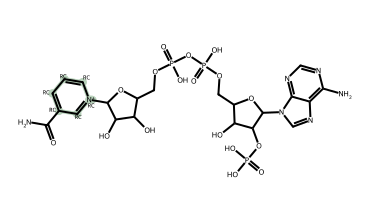

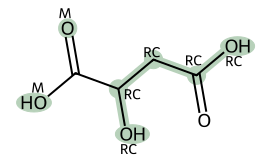

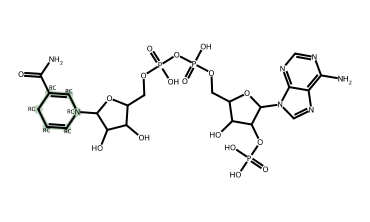

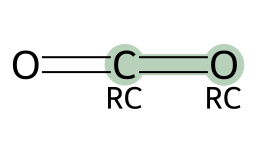

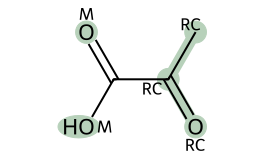

Entry ID: 61


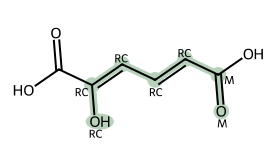

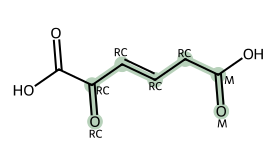

Entry ID: 65


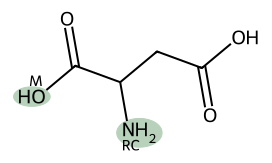

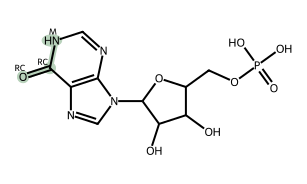

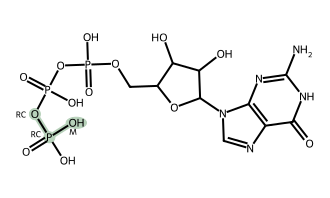

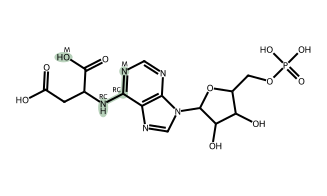

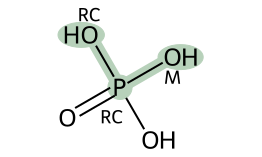

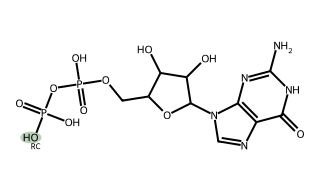

Entry ID: 73


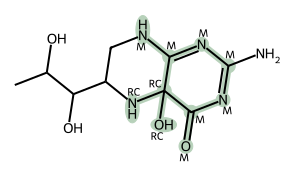

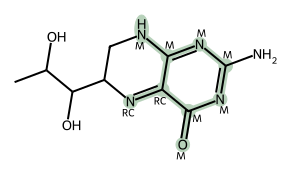

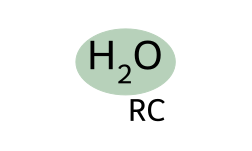

Entry ID: 182


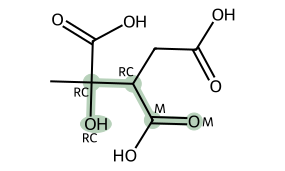

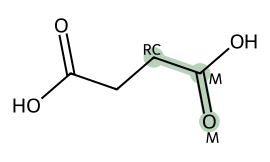

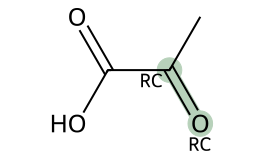

Entry ID: 190


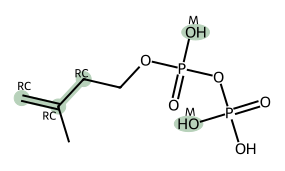

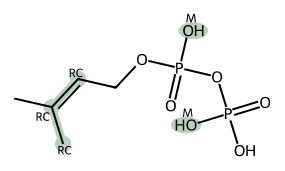

Entry ID: 236


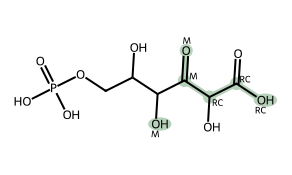

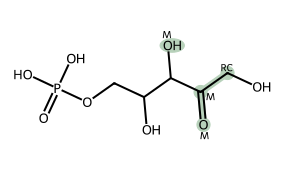

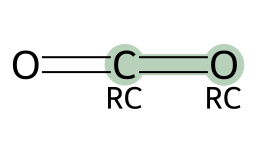

Entry ID: 253


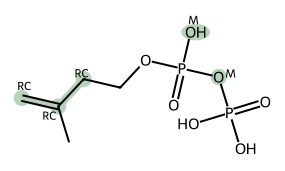

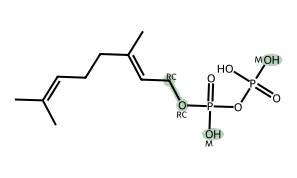

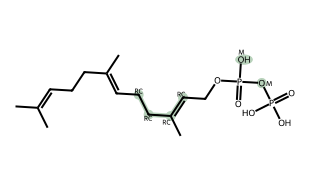

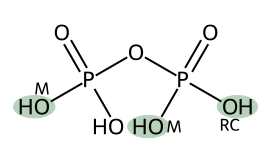

Entry ID: 269


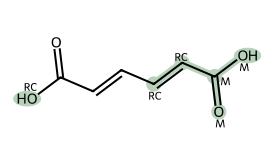

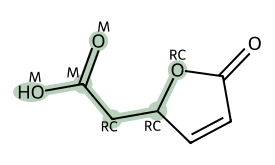

Entry ID: 272


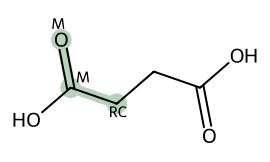

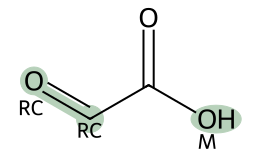

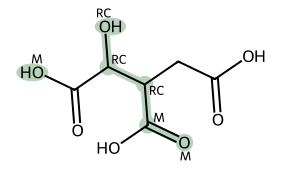

Entry ID: 311


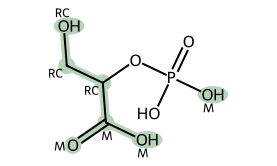

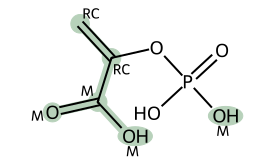

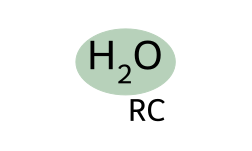

Entry ID: 451


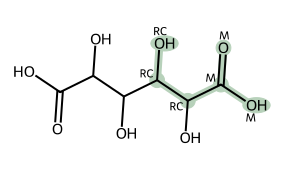

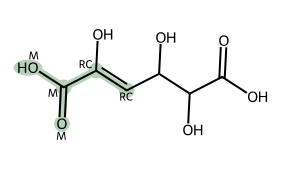

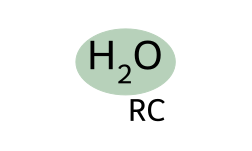

Entry ID: 468


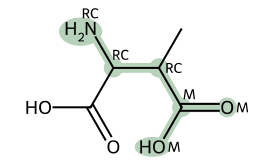

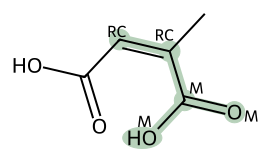

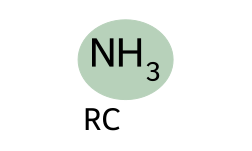

Entry ID: 502


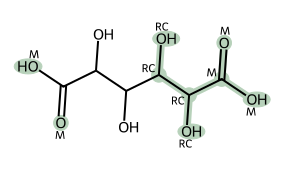

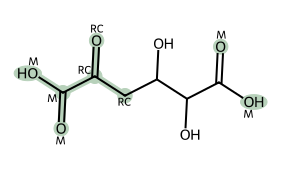

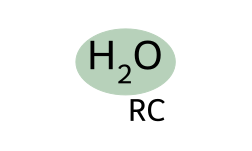

Entry ID: 569


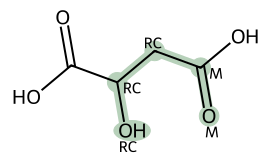

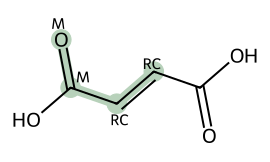

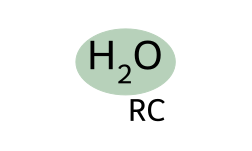

Entry ID: 741


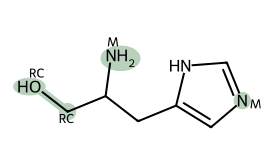

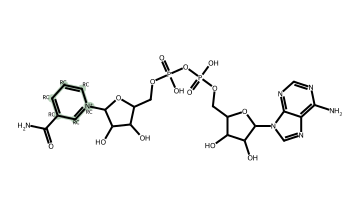

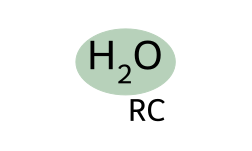

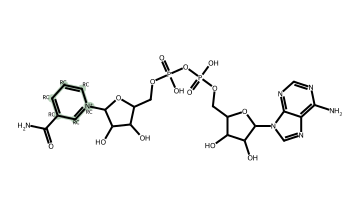

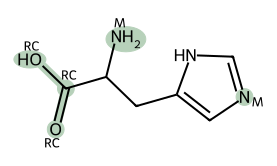

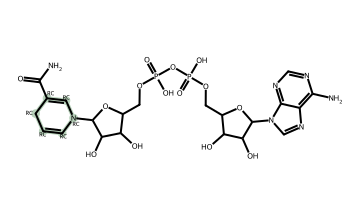

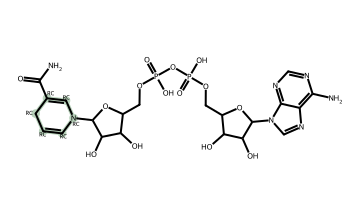

Entry ID: 759


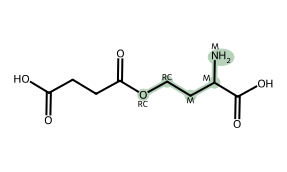

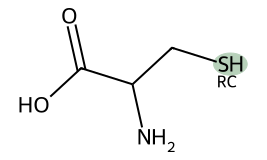

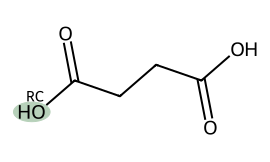

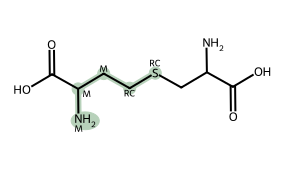

Entry ID: 846


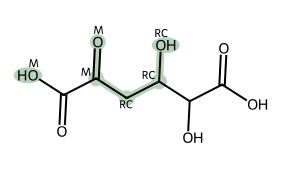

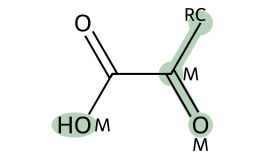

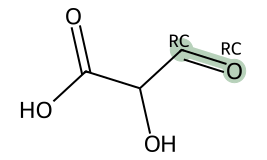

Entry ID: 874


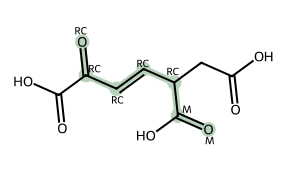

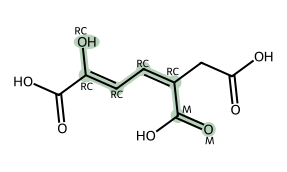

Entry ID: 933


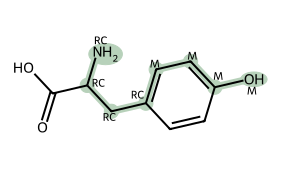

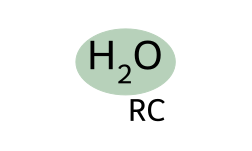

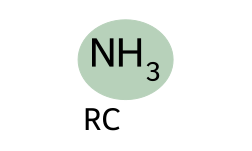

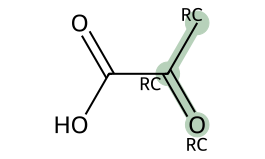

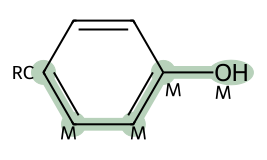

Entry ID: 963


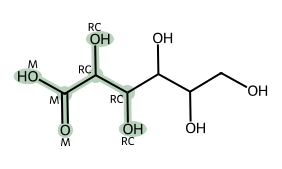

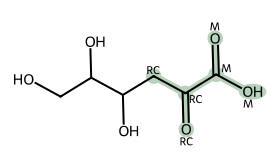

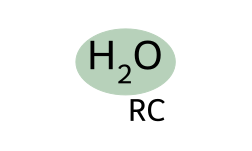

Entry ID: 722


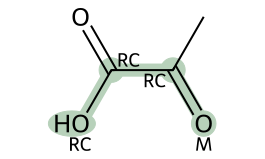

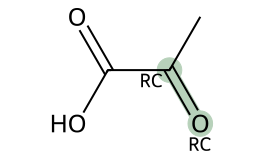

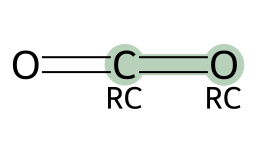

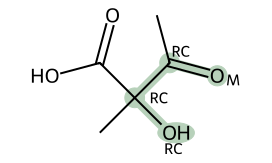

Entry ID: 1003


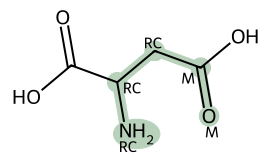

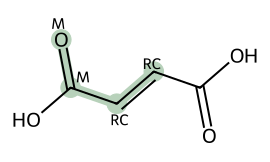

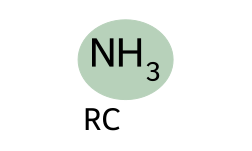

In [7]:
for entry in entries:
    row = mm.loc[mm['entry_id'] == entry].iloc[0]
    rc = row["reaction_center"]
    mech_atoms = row["mech_atoms"]
    smarts = row["smarts"]
    print(f"Entry ID: {entry}")
    draw_substrates_w_mech_rc_labeled(smarts, rc, mech_atoms, entry, save_to=Path(cfg.artifacts) / "figures" / "illustrative_mechinfo_templates")

In [8]:
entries_to_rhea = {
    21: [12654, 12655],
    61: [33432, 33433],
    65: [15754, 15755],
    73: [11921, 11922],
    182: [16810, 16811],
    190: [23285, 23286],
    236: [14354, 14355],
    253: [19362, 19363],
    269: [30032, 30033],
    272: [13246, 13247],
    311: [10165, 10166],
    451: [14574, 14575],
    468: [12830, 12831],
    502: [45809, 45810],
    569: [12461, 12462],
    741: [20642, 20643],
    759: [20398, 20399],
    846: [10269, 10270],
    874: [18814, 18815],
    933: [21705, 21706],
    963: [20098, 20099],
    722: [25250, 25251],
    1003: [16602, 16603],
}

In [9]:
krs = pd.read_parquet(
    Path(cfg.raw_data) / "known_reactions.parquet"
)
rhea_to_id = {}
for _, row in krs.iterrows():
    for rhea_id in row['db_ids']:
        rhea_id = int(rhea_id.removeprefix("RHEA:"))
        rhea_to_id[rhea_id] = row['id']

In [10]:
experiment_name = "outer_splits_v3" # outer_splits
mlflow.set_tracking_uri(f"file://{cfg.mlruns}")
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [11]:
preds = []
for _, row in df[df['params.objective'] == 'val_auprc'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,0,0.0,0.002419
1,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,1,1.0,0.999453
2,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,2,1.0,0.996991
3,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,3,0.0,0.000290
4,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,4,0.0,0.001314


In [12]:
mechinfo_maps = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_known_reactions_x_mechinformed_rules.parquet"
)
mechinfo_maps["template_aidxs"] = mechinfo_maps["template_aidxs"].apply(rc_to_nest)
mechinfo_maps.head()

,rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
0,4fc554b86bb64504ce3bb78f4c02accc82779129,*C#N.O>>*C(N)=O,[*:4][C:1]#[N:2].[OH2:3]>>[*:4][C:1]([NH2:2])=...,[C&D2&v4&H0&+0&!R&z2:1]#[N&D1&v3&H0&+0&!R:2].[...,"(((1, 2), (0,)), ((1, 2, 3),))",101
1,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,*C(=O)C(*)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP...,[*:3][C:1](=[O:2])[CH:4]([*:5])[C:6](=[O:7])[O...,[C&D3&v4&H0&+0&!R&z2:1]=[O&D1&v2&H0&+0&!R:2].[...,"(((1, 2), (3, 4, 5, 45, 46, 47)), ((1, 2), (3,...",452
2,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C...,[*:21][P:18](=[O:22])([OH:23])[O:15][CH2:11][C...,[*:1](~[O&D1&v2&H1&+0&!R:2])~[*:3]~[O&D2&v2&H0...,"(((19, 20, 21, 22, 23, 24), (5,)), ((19, 20, 2...",722
3,c82512d7ba8569c1c44dfb76137b3fea52ee6271,*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C...,[*:21][P:18](=[O:22])([OH:23])[O:15][CH2:11][C...,[*:1](~[O&D1&v2&H1&+0&!R:2])~[*:3]~[O&D2&v2&H0...,"(((19, 20, 21, 22, 23, 24), (5,)), ((19, 20, 2...",722
4,1df0c98f185e6581109d26af4be03ea93c490d63,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:4][C:1](=[O:2])[S:10][CH2:11][CH2:12][NH:...,[C&D3&v4&H0&+0&!R&z2:1](=[O&D1&v2&H0&+0&!R:2])...,"(((1, 2, 3), (5,)), ((5, 6, 8), (47,)))",39


In [15]:

def draw_prob_overlay(smarts: str, am_smarts: str, template_aidxs: tuple[tuple[tuple[int]]], probas: list[float], entry_id: int, size: tuple[int, int] = (250, 150), highlight_color: tuple = (0.72, 0.82, 0.73), save_to: Path = None):
    _draw_opts = {
        'useBWAtomPalette': None,
        'setHighlightColour': highlight_color,
        'annotationFontScale': 0.77,
    }
    denom = 100
    scl_size = lambda size, n_atoms: (int(size[0] * (1 + n_atoms / denom)), int(size[1] * (1 + n_atoms / denom)))

    if save_to is not None:
        (save_to / f"mcsa_{entry_id}").mkdir(parents=True, exist_ok=True)

    am_rcts, am_pdts = [[Chem.MolFromSmiles(smi) for smi in side.split('.')] for side in am_smarts.split(">>")]
    rcts, pdts = [[Chem.MolFromSmiles(smi) for smi in side.split('.')] for side in smarts.split(">>")]
    n_rct_atoms = [0] + list(accumulate([rct.GetNumAtoms() for rct in rcts]))

    rct_idx_aidx_proba = defaultdict(dict)
    pdt_idx_aidx_proba = defaultdict(dict)
    for i, (am_rct, n_rct_atom) in enumerate(zip(am_rcts, n_rct_atoms)):
        for idx, proba in enumerate(probas[n_rct_atom:n_rct_atoms[i + 1]]):
            rct_idx_aidx_proba[i][idx] = proba
            amn = am_rct.GetAtomWithIdx(idx).GetAtomMapNum()

            found_pdt_atom = False
            for j, pdt in enumerate(am_pdts):
                for pdt_idx, pdt_atom in enumerate(pdt.GetAtoms()):
                    if pdt_atom.GetAtomMapNum() == amn:
                        pdt_idx_aidx_proba[j][pdt_idx] = proba
                        found_pdt_atom = True
                        break
                if found_pdt_atom:
                    break

    for i, rct, hatoms in zip(range(len(rcts)), rcts, template_aidxs[0]):
        for idx, atom in enumerate(rct.GetAtoms()):
            proba = rct_idx_aidx_proba[i].get(idx, None)
            if proba is not None:
                atom.SetProp('atomNote', f"{proba:.2f}")

        _size = scl_size(size, rct.GetNumAtoms())
        img = draw_molecule(
                    rct,
                    size=_size,
                    highlight_atoms=hatoms,
                    draw_options=_draw_opts
                )
        display(SVG(img))

        if save_to is not None:
            img_path = save_to / f"mcsa_{entry_id}" / f"rct_{i}.svg"
            with open(img_path, 'w') as f:
                f.write(img)

    for i, pdt, hatoms in zip(range(len(pdts)), pdts, template_aidxs[1]):
        for idx, atom in enumerate(pdt.GetAtoms()):
            proba = pdt_idx_aidx_proba[i].get(idx, None)
            if proba is not None:
                atom.SetProp('atomNote', f"{proba:.2f}")

        _size = scl_size(size, pdt.GetNumAtoms())
        img = draw_molecule(
            pdt,
            size=_size,
            highlight_atoms=hatoms,
            draw_options=_draw_opts
        )
        display(SVG(img))

        if save_to is not None:
            img_path = save_to / f"mcsa_{entry_id}" / f"pdt_{i}.svg"
            with open(img_path, 'w') as f:
                f.write(img)

Entry ID: 21, RXN ID: cd01daf75dd6555ddced162027e44974a23d725d


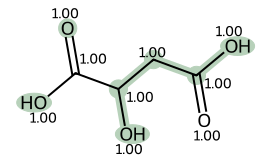

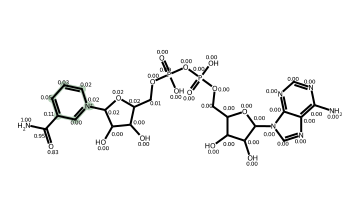

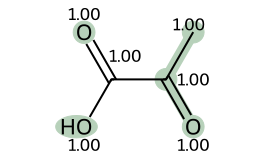

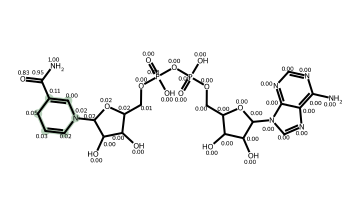

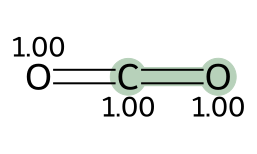

Entry ID: 61, RXN ID: ef8b21a6d806f66428ced999f8c799b3684603fb


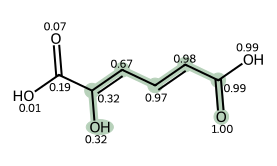

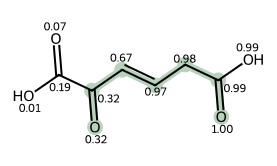

Entry ID: 65, RXN ID: 8ecbec0430c628be77dfcf56a12eead183c0307a


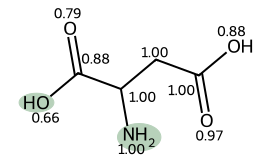

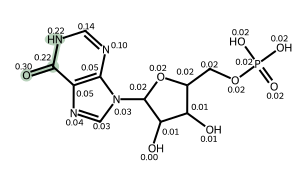

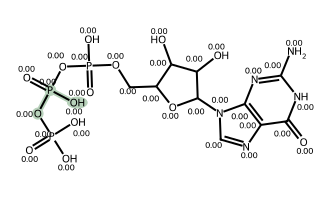

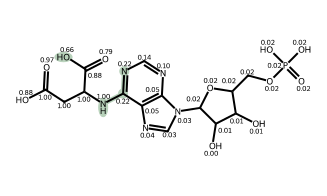

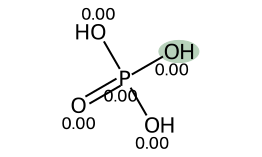

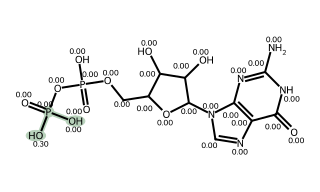

Entry ID: 73, RXN ID: 110389a33fe924d7436c1360cdb6cd5b9548ecc7


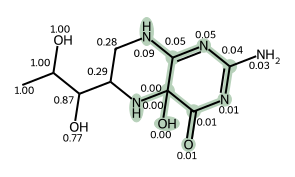

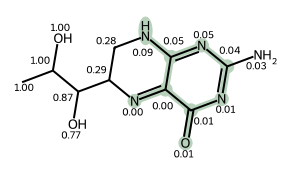

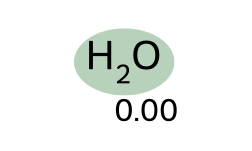

Entry ID: 182, RXN ID: 1f03b0aafc03df2bf8381697895818a5bd60ab1c


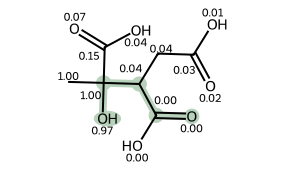

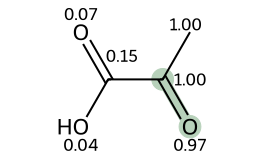

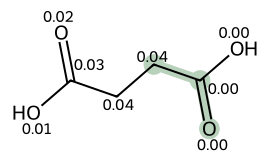

Entry ID: 190, RXN ID: 132c1157ed9cf0b496dfb7818f155cfebfa8388e


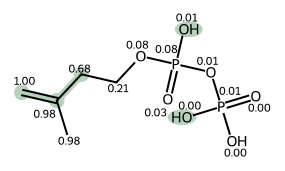

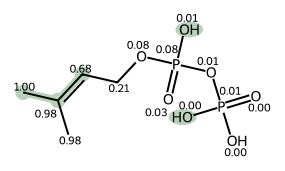

Entry ID: 236, RXN ID: 647a7c13fcc9350cad897bbc7dd90ea42d40156b


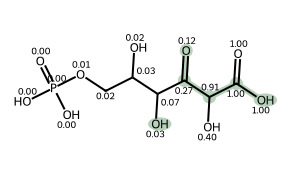

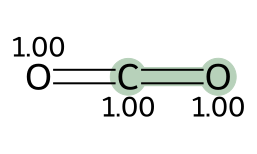

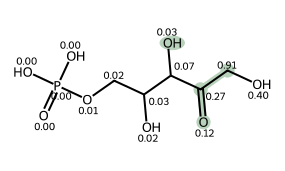

Entry ID: 253, RXN ID: c8c209f286a6937ea33c7ef2da5e1f8ff474f9c4


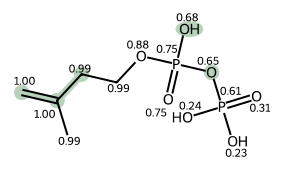

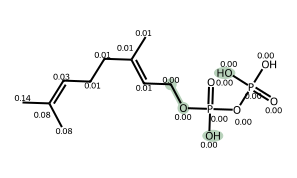

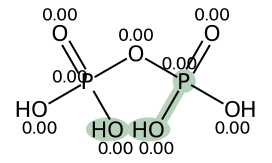

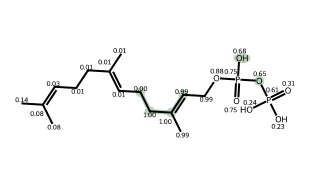

Entry ID: 269, RXN ID: 1662d8e4f7ef3f42b160e0acbac8978846fbe95b


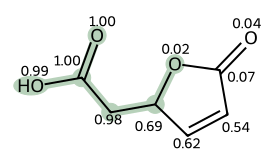

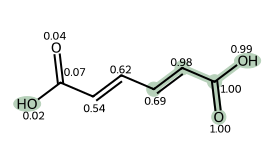

Entry ID: 272, RXN ID: b33862016947ae4d869b431d747e18194e26b51e


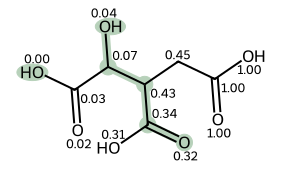

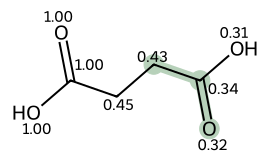

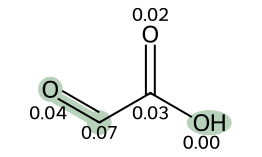

Entry ID: 311, RXN ID: 56133ecb2c6f21cbc3fbcb9eb4c5aa67274e7dec


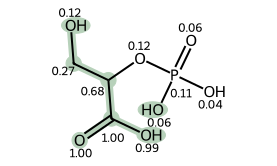

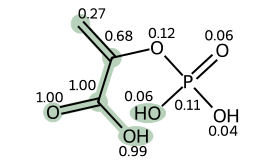

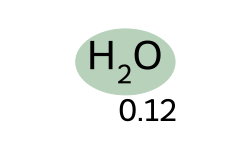

Entry ID: 451, RXN ID: 4f95b626315e47c2dd4463562e75ce0d2fe7b52a


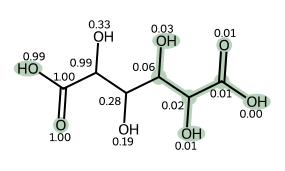

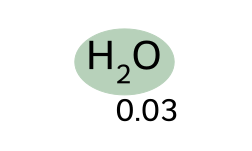

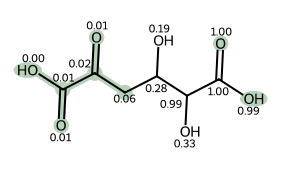

Entry ID: 468, RXN ID: b9e3f9be5d85a9fc4fbf6e682d778a1e58cc3728


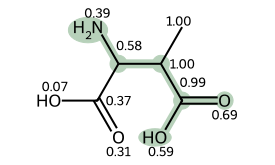

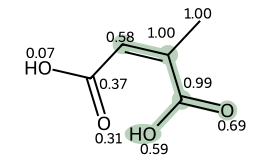

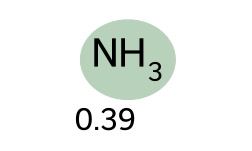

Entry ID: 502, RXN ID: 4f95b626315e47c2dd4463562e75ce0d2fe7b52a


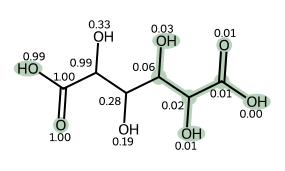

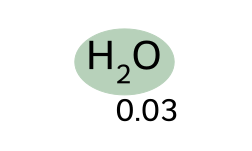

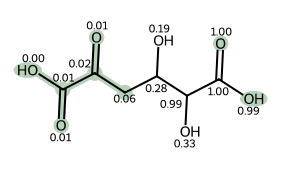

Entry ID: 569, RXN ID: 940b6c40eb8dd019d3a27b563e73ec10d1665ff1


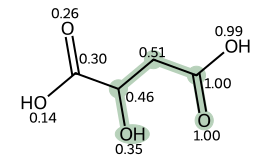

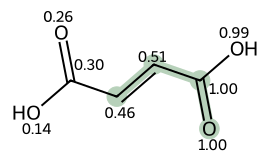

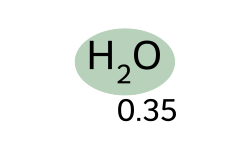

Entry ID: 741, RXN ID: 21adde9f2957d39194f732b90112d742872a1f05


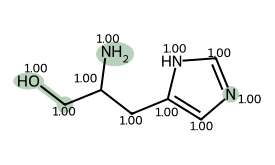

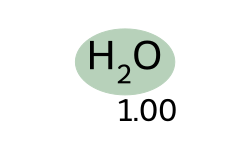

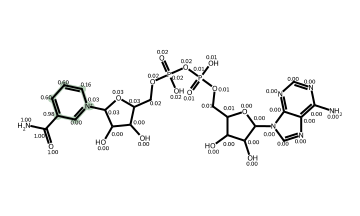

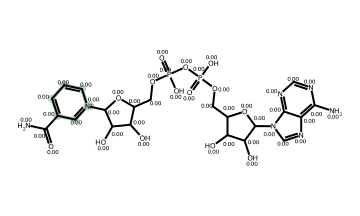

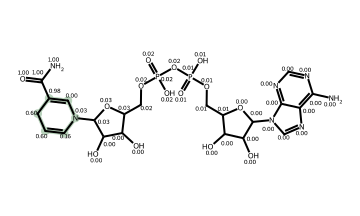

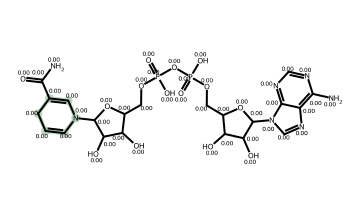

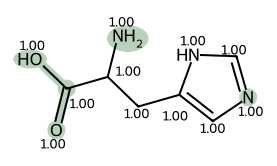

Entry ID: 759, RXN ID: cf1b8fc757b3ac2c41f4670f31245dad8030fa8d


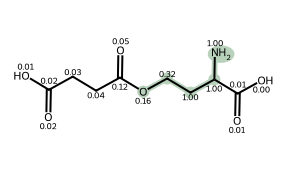

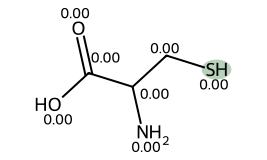

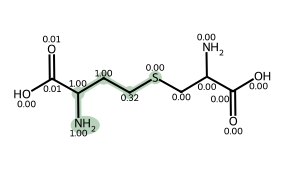

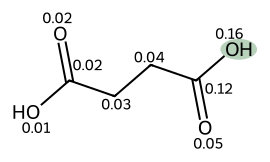

Entry ID: 846, RXN ID: 978310004081b9802233c0e6f8641fb5b6797d0a


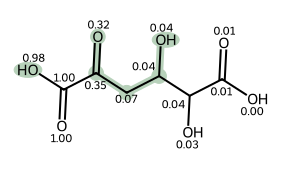

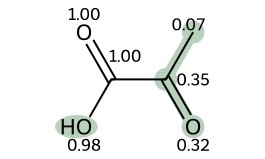

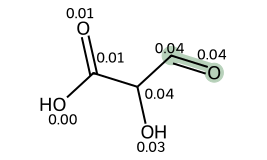

Entry ID: 874, RXN ID: 34c208aff095f8a77f6eecc297cb0d38cdb57ee5


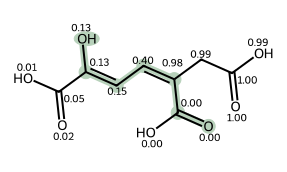

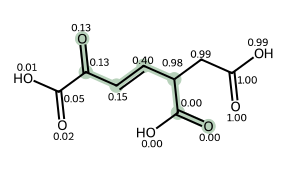

Entry ID: 933, RXN ID: 6df2f32f329cc14f6211c7d6d120e9189ebf2c9d


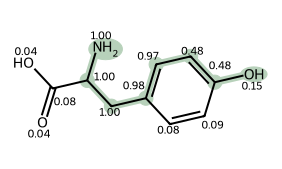

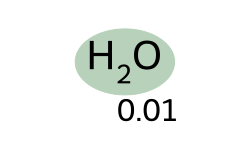

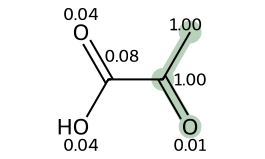

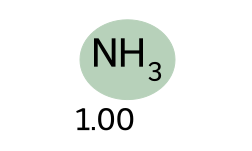

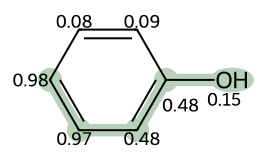

Entry ID: 963, RXN ID: 8eb26e3422b37733ee779f84fbd020a234fb8854


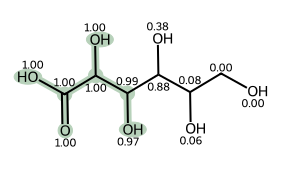

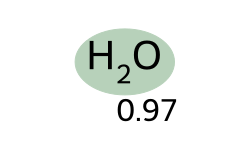

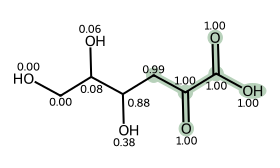

Entry ID: 722, RXN ID: b937c515e2a304d9439c12d4ed0412bf9248781a


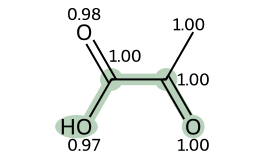

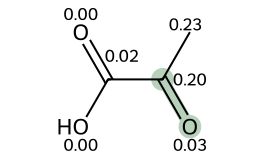

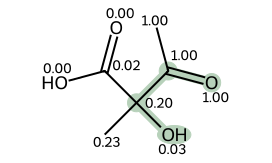

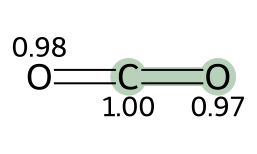

Entry ID: 1003, RXN ID: 2fb94d6fb8a54e26f55c893dfb59a5bd3d1e4fff


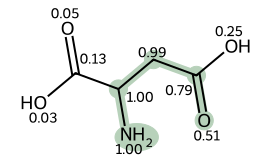

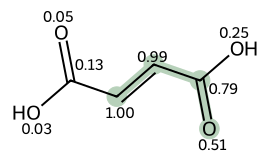

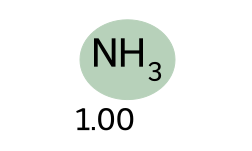

In [16]:
smarts2id = dict(zip(mechinfo_maps["smarts"], mechinfo_maps["rxn_id"]))
for entry, rhea_ids in entries_to_rhea.items():
    rhea_id = rhea_ids[0]
    rxn_id = rhea_to_id[rhea_id]
    row = mechinfo_maps.loc[mechinfo_maps['rxn_id'] == rxn_id].iloc[0]
    template_aidxs = row['template_aidxs']
    smarts = row['smarts']
    am_smarts = row['am_smarts']
    probas = pred_df.loc[pred_df['rxn_id'] == rxn_id, 'y_pred'].sort_values(ascending=False).to_list()
    print(f"Entry ID: {entry}, RXN ID: {rxn_id}")
    scrubbed_template_aidxs = scrub_anonymous_template_atoms(template_aidxs, row['rule'])
    draw_prob_overlay(smarts, am_smarts, scrubbed_template_aidxs, probas, entry, save_to=Path(cfg.artifacts) / "figures" / "illustrative_prob_overlays")
        